In [47]:
# utils and general stuff
import pandas as pd
import numpy as np
from exam_utils import timeParser
import re
from sklearn.metrics import cohen_kappa_score

#Packages to create DFM
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize import TweetTokenizer

#Models to train
from sklearn.linear_model import LogisticRegression

#Packages for cross-validation and parameter tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, classification_report

In [7]:
df = pd.read_csv('lemma_all.csv', compression='zip')

In [8]:
df.loc[:, 'tweet_created_at'] = df.tweet_created_at.apply(timeParser)

In [9]:
# subsetting only after the electiong and making a copy to get rid of the setting with copy warning
df_ae = df.loc[df.tweet_created_at > '2019-06-05'].copy()  

In [10]:
df_ae.loc[:, 'tweet_id'] = df_ae.loc[:, 'tweet_id'].astype(int)

In [11]:
# removing all retweets
df_ae = df_ae.loc[~df_ae.tweet_full_text.str.contains('^RT')]

# dropping nans in tweet lemma
df_ae = df_ae.dropna(subset=['tweet_text_lemma'])

In [30]:
def sample_dataset(df, n=100, random_state=42):
    '''Takes in a df and returns 100 random tweets to be labelled'''
    temp = df.sample(n, random_state=random_state)
    temp.loc[:, 'label'] = np.nan
    return temp

In [31]:
# Getting the first dataset to label!
label = sample_dataset(df_ae)

In [32]:
label.to_excel('label_this.xlsx')

In [27]:
label_9 = pd.read_csv('label9.csv', index_col=0)

# Active learning loop

## importing data and splitting into X and y

In [14]:
def split_data(path, test_data=False):
    '''takes in the path to the latest labelled data set and returns X_train, y_train, and a df
    could have used train_test_split'''
    new_df = pd.read_csv(path)
    X = new_df.tweet_text_lemma
    y = new_df.label
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    if test_data:
        return X_train, X_test, y_train, y_test, new_df
    else:
        return X, y, new_df

In [2]:
def get_unlabelled(new_df, old_df):
    '''takes in the new df and removes the ones in the new one from the old one'''
    unlabelled_df = old_df.loc[~old_df.index.isin(new_df.index)]
    return unlabelled_df

In [15]:
X_train, X_test, y_train, y_test, labelled_df = split_data('label10.csv', test_data=True)

In [16]:
X_test.shape

(220,)

In [30]:
unlabelled_df = get_unlabelled(labelled_df, df_ae)

In [3]:
# pipeline to train on
tokenizer = TweetTokenizer()

pipeline = Pipeline([ 
    ('cv', CountVectorizer(tokenizer=tokenizer.tokenize, ngram_range = (1, 2), max_df=0.999, min_df=0.01)),
    ('tfidf', TfidfTransformer(use_idf = False)),
    ('logreg', LogisticRegression())
])

In [17]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.999, min_df=0.01, ngram_range=(1, 2),
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7f8e5f0f0710>>)),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('logreg', LogisticRegression())])

In [9]:
def predict_unlabelled(pipeline, unlabelled_df):
    '''takes in a pipeline, the unlabelled df and adds the maximum probability column
    Then it sorts the dataframe by max proba and returns it'''
    # predicts for the three classes for all entries in the dataset
    predictions = pipeline.predict_proba(unlabelled_df.tweet_text_lemma)
    # creates a column with the max probability
    temp = unlabelled_df.copy()
    temp.loc[:, 'max_proba'] = [max(pred) for pred in predictions]
    return temp

In [34]:
unlabelled_df = predict_unlabelled(pipeline, unlabelled_df)


In [35]:
def label_new_set(unlabelled_df, labelled_df, new_name):
    '''takes in the df produced above, sorts it and saves a new df to be labelled'''
    unlabelled_df.sort_values(by='max_proba', inplace=True)
    new_df = unlabelled_df[:100].copy()
    new_df.loc[:, 'label'] = np.nan
    new_df = pd.concat([new_df, labelled_df])
    new_df.to_excel(f'{new_name}.xlsx')
    return None

In [36]:
label_new_set(unlabelled_df, labelled_df, 'label10')

## Checking the current score

Implement function that calculates [Cohens kappa](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html) between the unlabelled set between iterations; Wiedemann proposes to stop when it reaches 0.99 after three revisions; we probably need to settle a bit lower.

In [11]:
def cohens_kappa(path_to_labelled, full_df):
    '''takes in a labelled dict and an unlabelled dict. Fits a model for each hundred labelled entries
    predicts on the unlabelled set and then calculates cohens kappa for each models prediction
    and the former iterations and returns a list of cohens kappa scores for each iteration
    Could also be augmented to print the score each iteration'''
    df = pd.read_excel(path_to_labelled, index_col=0)
    unlabelled_df = get_unlabelled(df, full_df)
    X_test = unlabelled_df.tweet_text_lemma
    predictions = []
    
    n = df.shape[0]
    for i in range(100, n + 100, 100):
        # creates a temp df with only the n lowest labelled examples
        temp_df = df.tail(i).copy()
        X = temp_df.tweet_text_lemma
        y = temp_df.label
        pipeline.fit(X, y)
        predictions.append(pipeline.predict(X_test))
    kappas = []
    for i, prediction in enumerate(predictions):
        if (i + 1) == len(predictions):
            break
        else:
            kappas.append(cohen_kappa_score(prediction, predictions[i + 1]))
    return kappas

In [23]:
kappas = cohens_kappa('label10.xlsx', df_ae)

In [31]:
kappa_df = pd.DataFrame(kappas, columns=["Cohen's kappa score"], index=index)

In [37]:
print(kappa_df.to_markdown())

|    |   Cohen's kappa score |
|---:|----------------------:|
|  1 |              0        |
|  2 |              0.68688  |
|  3 |              0.607777 |
|  4 |              0.484773 |
|  5 |              0.682985 |
|  6 |              0.727122 |
|  7 |              0.79934  |
|  8 |              0.807076 |
|  9 |              0.807039 |
| 10 |              0.84945  |


In [38]:
kappa_df.to_csv('cohens\ kappas.csv')

## Leftovers

In [ ]:
#Fill in the parameter values in the grid 
parameter_grid = {
    'tfidf__use_idf': [False, True],
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],
    'logreg__C': [0.1, 0.5, 1],
}

#Initializing a kfold with 5 folds
cv = StratifiedKFold(n_splits=5)

#Initializing the GridSearchCV
search = GridSearchCV(pipeline, parameter_grid, cv=cv, n_jobs = -1, verbose=10)

In [ ]:
search.fit(X_train, y_train)

In [53]:
pipeline.score(X_train, y_train)

0.778

In [55]:
y_pred = pipeline.predict(X_train)

In [57]:
conf = confusion_matrix(y_train, y_pred)

In [58]:
print(conf)

[[209   3   0   3]
 [ 51  75   1   5]
 [ 35   6  36   1]
 [  5   0   1  69]]


## Visualizing

In [39]:
y_pred = pipeline.predict(X_test)

In [40]:
y_test = np.array(y_test)

In [41]:
confusion_matrix(y_test, y_pred)

array([[48, 17,  4, 15],
       [26, 16,  3,  8],
       [16,  8,  8,  6],
       [ 3,  2,  2, 38]])

In [42]:
categories = ['Neutral', 'Negative', 'Positive', 'Not climate']
logreg_eval = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=categories, index=categories)

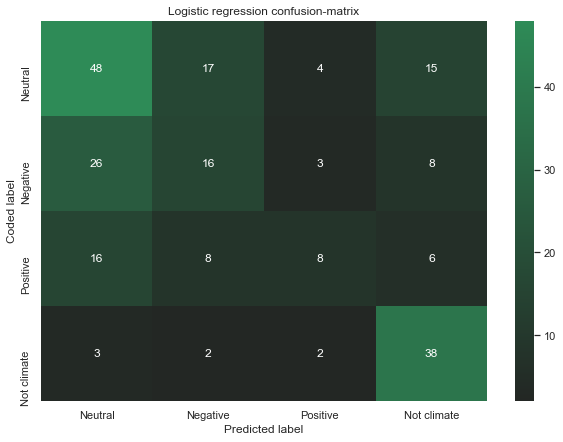

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

def heatmap(confusion_df, title):
    cmap = sns.dark_palette('seagreen', as_cmap=True)
    plt.figure(figsize = (10,7))
    sns.heatmap(confusion_df, annot=True, cmap=cmap)
    plt.xlabel('Predicted label')
    plt.ylabel('Coded label')
    plt.yticks(rotation=90)
    plt.title(title)

    plt.savefig(title, format='png')
    
heatmap(logreg_eval, 'Logistic regression confusion-matrix')

In [48]:
class_report_logreg = pd.DataFrame(classification_report(y_test, y_pred, target_names=categories, output_dict=True))

In [50]:
logreg_scores = class_report_logreg.loc[['precision', 'recall', 'f1-score'], ['Neutral', 'Negative', 'Positive', 'Not climate']]
print(logreg_scores.to_markdown())

|           |   Neutral |   Negative |   Positive |   Not climate |
|:----------|----------:|-----------:|-----------:|--------------:|
| precision |  0.516129 |   0.372093 |   0.470588 |      0.567164 |
| recall    |  0.571429 |   0.301887 |   0.210526 |      0.844444 |
| f1-score  |  0.542373 |   0.333333 |   0.290909 |      0.678571 |


## Cohens K: AE & EG

In [5]:
df_anton = pd.read_excel('label7_ae.xlsx', index_col=0)
df_emilie = pd.read_excel('label7_eg.xlsx', index_col=0)

In [21]:
df_anton.to_csv('label7_totest.csv')

In [12]:
labels_a = df_anton.head(200).label
labels_e = df_emilie.head(200).label

In [13]:
cohen_kappa_score(labels_a, labels_e)

0.6644647163678306

In [31]:
df_anton.loc[:, 'emilies_labels'] = df_emilie.loc[:, 'label'].copy()

In [33]:
df_anton.loc[df_anton.label != df_anton.emilies_labels].to_csv('uenige_eg_an.csv')